<a href="https://colab.research.google.com/github/cvt220106/google-colab/blob/main/tf04_10_monkeys_model_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import json
token = {"username":"jackyyoung","key":"8b0d8fc1f1c33da831ade74e571a01c7"}
with open('/content/kaggle.json','w') as file:
	json.dump(token,file)
# 采用json.dump的好处在于,写入文件的同时,还能保存token的字典格式

In [3]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle config set -n path -v /content

- path is now set to: /content


In [4]:
!kaggle datasets download -d slothkong/10-monkey-species

100% 547M/547M [00:10<00:00, 66.0MB/s]
100% 547M/547M [00:10<00:00, 52.9MB/s]


In [5]:
!ls

datasets  kaggle.json  sample_data


In [6]:
!unzip -o -d /content /content/datasets/slothkong/10-monkey-species/10-monkey-species.zip

Archive:  /content/datasets/slothkong/10-monkey-species/10-monkey-species.zip
  inflating: /content/monkey_labels.txt  
  inflating: /content/training/training/n0/n0018.jpg  
  inflating: /content/training/training/n0/n0019.jpg  
  inflating: /content/training/training/n0/n0020.jpg  
  inflating: /content/training/training/n0/n0021.jpg  
  inflating: /content/training/training/n0/n0022.jpg  
  inflating: /content/training/training/n0/n0023.jpg  
  inflating: /content/training/training/n0/n0024.jpg  
  inflating: /content/training/training/n0/n0025.jpg  
  inflating: /content/training/training/n0/n0026.jpg  
  inflating: /content/training/training/n0/n0027.jpg  
  inflating: /content/training/training/n0/n0028.jpg  
  inflating: /content/training/training/n0/n0029.jpg  
  inflating: /content/training/training/n0/n0030.jpg  
  inflating: /content/training/training/n0/n0031.jpg  
  inflating: /content/training/training/n0/n0032.jpg  
  inflating: /content/training/training/n0/n0033.jpg  


In [8]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
import time

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.8.2
sys.version_info(major=3, minor=7, micro=13, releaselevel='final', serial=0)
matplotlib 3.2.2
numpy 1.21.6
pandas 1.3.5
sklearn 1.0.2
tensorflow 2.8.2
keras.api._v2.keras 2.8.0


In [9]:
train_dir = "./training/training"
valid_dir = "./validation/validation"
label_file = "./monkey_labels.txt"
print(os.path.exists(train_dir))
print(os.path.exists(valid_dir))
print(os.path.exists(label_file))

print(os.listdir(train_dir))
print(os.listdir(valid_dir))

True
True
True
['n5', 'n4', 'n0', 'n1', 'n6', 'n8', 'n2', 'n3', 'n7', 'n9']
['n5', 'n4', 'n0', 'n1', 'n6', 'n8', 'n2', 'n3', 'n7', 'n9']


In [10]:
labels = pd.read_csv(label_file, header=0)
print(labels)

   Label     Latin Name              Common Name                     \
0  n0         alouatta_palliata\t    mantled_howler                   
1  n1        erythrocebus_patas\t    patas_monkey                     
2  n2        cacajao_calvus\t        bald_uakari                      
3  n3        macaca_fuscata\t        japanese_macaque                 
4  n4       cebuella_pygmea\t        pygmy_marmoset                   
5  n5       cebus_capucinus\t        white_headed_capuchin            
6  n6       mico_argentatus\t        silvery_marmoset                 
7  n7      saimiri_sciureus\t        common_squirrel_monkey           
8  n8       aotus_nigriceps\t        black_headed_night_monkey        
9  n9       trachypithecus_johnii    nilgiri_langur                   

    Train Images    Validation Images  
0             131                  26  
1             139                  28  
2             137                  27  
3             152                  30  
4             131 

In [11]:
height = 128
width = 128
channels = 3
batch_size = 64
num_classes = 10

train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,#图片中的每个像素点都乘以1/255
    rotation_range = 40,#把图形随机旋转一个角度，在0-40度之间
    width_shift_range = 0.2,#位移，0-20%之间选择做偏移
    height_shift_range = 0.2,#垂直方向位移，如果是0-1之间的数，就是比例，大于1就是像素
    shear_range = 0.2,#剪切强度（逆时针剪切角，以度为单位）
    zoom_range = 0.2,#缩放强度
    horizontal_flip = True,#水平随机翻转
    fill_mode = 'nearest',#图形放大后，有些地方需要填充，
#  可以是“常数”，“最近”，“反射”或“环绕”之一。默认值为“最近”。输入边界之外的点将根据给定模式进行填充
)
#读取图片
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    #生成图片多大
                                                   target_size = (height, width),
                                                    #生成的图片以多少张为一组
                                                   batch_size = batch_size,
                                                   seed = 7,
                                                   shuffle = True,
                                                    #one-hot编码后的一种模式
                                                   class_mode = "categorical")
#对验证集必须做一个值的缩放，其他的不需要做
valid_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                    target_size = (height, width),
                                                    batch_size = batch_size,
                                                    seed = 7,
                                                    shuffle = False,
                                                    class_mode = "categorical")
train_num = train_generator.samples
valid_num = valid_generator.samples
print(train_num, valid_num)

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.
1098 272


In [12]:
for i in range(1):
    x, y = train_generator.next()
    print(x.shape, y.shape)
    print(y)

(64, 128, 128, 3) (64, 10)
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.

In [13]:
model = keras.models.Sequential([
    #第一组卷积
    keras.layers.Conv2D(filters=32, kernel_size=3, padding='same',
                        activation='relu', input_shape=[width, height, channels]),
    keras.layers.Conv2D(filters=32, kernel_size=3, padding='same',
                        activation='relu'),
    keras.layers.MaxPool2D(pool_size=2),
    #第二组翻倍
    keras.layers.Conv2D(filters=64, kernel_size=3, padding='same',
                        activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=3, padding='same',
                        activation='relu'),
    keras.layers.MaxPool2D(pool_size=2),
    #第三组再翻倍
    keras.layers.Conv2D(filters=128, kernel_size=3, padding='same',
                        activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=3, padding='same',
                        activation='relu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Flatten(),
    #展平后，和全连接层做连接
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax'),
])

model.compile(loss="categorical_crossentropy",
              optimizer="adam", metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                    

In [14]:
len(model.layers)

12

In [15]:
epochs = 20
#如果机器性能好，可以把epochs改为300
history = model.fit(train_generator,
                              #显试指定
                              steps_per_epoch = train_num // batch_size,
                              epochs = epochs,
                              validation_data = valid_generator,
                              validation_steps = valid_num // batch_size)

Epoch 1/20
17/17 [==============================] - 47s 2s/step - loss: 2.3103 - accuracy: 0.1167 - val_loss: 2.2844 - val_accuracy: 0.1758
Epoch 2/20
17/17 [==============================] - 32s 2s/step - loss: 2.2999 - accuracy: 0.1209 - val_loss: 2.2926 - val_accuracy: 0.1445
Epoch 3/20
17/17 [==============================] - 32s 2s/step - loss: 2.2633 - accuracy: 0.1470 - val_loss: 2.1099 - val_accuracy: 0.2305
Epoch 4/20
17/17 [==============================] - 32s 2s/step - loss: 2.1026 - accuracy: 0.2311 - val_loss: 2.0510 - val_accuracy: 0.2148
Epoch 5/20
17/17 [==============================] - 32s 2s/step - loss: 2.0467 - accuracy: 0.2524 - val_loss: 1.9390 - val_accuracy: 0.3125
Epoch 6/20
17/17 [==============================] - 32s 2s/step - loss: 1.9785 - accuracy: 0.2892 - val_loss: 1.9640 - val_accuracy: 0.3398
Epoch 7/20
17/17 [==============================] - 32s 2s/step - loss: 1.9109 - accuracy: 0.3162 - val_loss: 1.9245 - val_accuracy: 0.3711
Epoch 8/20
17/17 [==

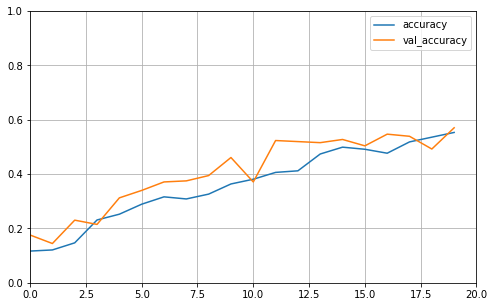

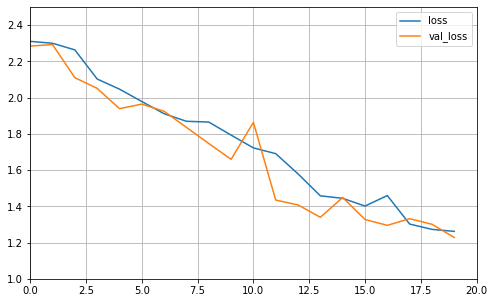

In [17]:
def plot_learning_curves(history, label, epcohs, min_value, max_value):
    data = {}
    data[label] = history.history[label]
    data['val_'+label] = history.history['val_'+label]
    pd.DataFrame(data).plot(figsize=(8, 5))
    plt.grid(True)
    plt.axis([0, epochs, min_value, max_value])
    plt.show()
#因为accuracy的值和loss值的范围很不一样，因此我们打印两条曲线
plot_learning_curves(history, 'accuracy', epochs, 0, 1)
plot_learning_curves(history, 'loss', epochs, 1, 2.5)

可以看到,直接使用深层神经网络进行分类时,效果并不是很好,初次训练的收敛速率过慢,准确率较低